In [1]:
import pandas as pd
from FinancialMachineLearning.features.fracdiff import FractionalDifferentiatedFeatures
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import yfinance as yf

start_date = '1962-01-01'
end_date = '2024-01-18'
ticker = 'XOM'

data = yf.download(ticker, start_date, end_date)
data.drop('Adj Close', axis = 1, inplace = True)
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
1962-01-02,0.000000,1.589844,1.578125,1.578125,902400
1962-01-03,0.000000,1.601563,1.578125,1.601563,1200000
1962-01-04,0.000000,1.613281,1.597656,1.605469,1088000
1962-01-05,0.000000,1.613281,1.566406,1.570313,1222400
1962-01-08,0.000000,1.582031,1.546875,1.566406,1388800
...,...,...,...,...,...
2024-01-10,99.800003,99.800003,98.160004,98.690002,18206100
2024-01-11,99.040001,99.500000,98.559998,98.669998,15833400
2024-01-12,100.139999,100.650002,99.169998,99.949997,18032100


In [3]:
data_ret = np.log(data.Close / data.Close.shift(1)).dropna()
data_ret.head()

Date
1962-01-03    0.014743
1962-01-04    0.002436
1962-01-05   -0.022141
1962-01-08   -0.002491
1962-01-09   -0.002497
Name: Close, dtype: float64

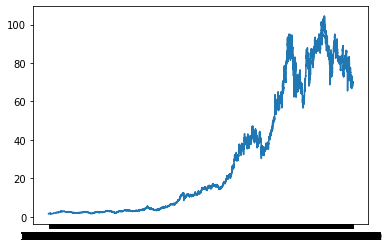

In [10]:
plt.plot(data.Close)

In [7]:
#분수 차분 계산 후, 얻어진 시계열의 정상성과 원래 데이터 간 상관성 평가
def calculate_difference(df : pd.DataFrame, end = 1, numbers = 11) :
    cols = ['adfStat','p-value','lags','nObs','95% conf', 'corr']
    out = pd.DataFrame(columns = cols)
    for d in np.linspace(0, end, numbers): #numbers개의 분수차수 생성
        try:
            df1 = np.log(df).dropna()
            #분수차분 실행(d : 분수 차수, thres : 임계값)
            df2 = FractionalDifferentiatedFeatures.fracDiff(df1, d, thres = 1e-5)
            #ADF 검정과 상관성 계산(기존 데이터와 분수 차분 데이터 간 상관계수)
            corr = np.corrcoef(df1.loc[df2.index, 'Close'], df2['Close'])[0,1]
            df2 = sm.tsa.stattools.adfuller(df2['Close'], maxlag = 1, regression = 'c', autolag = None)
            #계산된 ADF 통계량, p값, 상관계수 등 저장
            out.loc[d] = list(df2[:4]) + [df2[4]['5%']] + [corr]
        except Exception as e:
            print(f'd: {d}, error: {e}')
            continue
    return out

data_d = calculate_difference(data[['Close']], numbers = 21)

C:\Users\cksdu\OneDrive\문서\바탕 화면\FIND-A\MLFINLAB\FinancialMachineLearning\features\fracdiff.py:54: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_ = pd.Series()
C:\Users\cksdu\OneDrive\문서\바탕 화면\FIND-A\MLFINLAB\FinancialMachineLearning\features\fracdiff.py:54: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_ = pd.Series()
C:\Users\cksdu\OneDrive\문서\바탕 화면\FIND-A\MLFINLAB\FinancialMachineLearning\features\fracdiff.py:54: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_ = pd.Series()
C:\Users\cksdu\OneDrive\문서\바탕 화면\FIND-A\MLFINLAB\FinancialMachineLearning\features\fracdiff.py:54: FutureWarning: The default dtype for empty Series will be 'ob

In [8]:
data_d

,adfStat,p-value,lags,nObs,95% conf,corr
0.00,-0.892083,7.905684e-01,1.0,14597.0,-2.861738,1.000000
0.05,-0.325455,9.218210e-01,1.0,4.0,-4.474365,0.999007
0.10,-0.381350,9.131663e-01,1.0,4.0,-4.474365,0.996126
0.15,-1.720336,4.206663e-01,1.0,6.0,-3.646238,0.984297
0.20,-1.707622,4.271898e-01,1.0,8.0,-3.367187,0.967079
0.25,-4.244201,5.541346e-04,1.0,13.0,-3.127149,0.932946
0.30,-3.615943,5.463453e-03,1.0,19.0,-3.031227,0.892474
0.35,-2.630868,8.678379e-02,1.0,30.0,-2.964071,0.898378
0.40,-3.103146,2.632127e-02,1.0,47.0,-2.925338,0.841688
0.45,-4.141121,8.275645e-04,1.0,75.0,-2.900925,0.704957


,adfStat,p-value,lags,nObs,95% conf,corr
0.00,-0.892083,7.905684e-01,1.0,14597.0,-2.861738,1.000000
0.05,-0.325455,9.218210e-01,1.0,4.0,-4.474365,0.999007
0.10,-0.381350,9.131663e-01,1.0,4.0,-4.474365,0.996126
0.15,-1.720336,4.206663e-01,1.0,6.0,-3.646238,0.984297
0.20,-1.707622,4.271898e-01,1.0,8.0,-3.367187,0.967079
0.25,-4.244201,5.541346e-04,1.0,13.0,-3.127149,0.932946
0.30,-3.615943,5.463453e-03,1.0,19.0,-3.031227,0.892474
0.35,-2.630868,8.678379e-02,1.0,30.0,-2.964071,0.898378
0.40,-3.103146,2.632127e-02,1.0,47.0,-2.925338,0.841688
0.45,-4.141121,8.275645e-04,1.0,75.0,-2.900925,0.704957


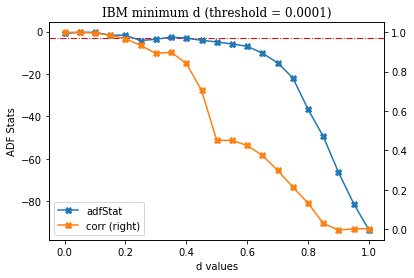

In [9]:
import matplotlib.pyplot as plt

f,ax = plt.subplots()
ax.axhline(data_d['95% conf'].mean(), lw = 1, color = 'r', ls = '-.')
data_d[['adfStat', 'corr']].plot(ax = ax, marker = 'X', secondary_y = 'corr')
ax.set_title('IBM minimum d (threshold = 0.0001)', fontsize = 12, fontfamily = 'Serif')
ax.set_xlabel('d values')
ax.set_ylabel('ADF Stats')
ax.grid(False)
display(data_d)

In [4]:
#0.45차분으로 
frac = FractionalDifferentiatedFeatures.fracDiff_FFD(data[['Close']], 0.35)
data['fracdiff'] = frac

In [5]:
data

,Open,High,Low,Close,Volume,fracdiff
Date,,,,,,
1962-01-02,0.000000,1.589844,1.578125,1.578125,902400,NaN
1962-01-03,0.000000,1.601563,1.578125,1.601563,1200000,NaN
1962-01-04,0.000000,1.613281,1.597656,1.605469,1088000,NaN
1962-01-05,0.000000,1.613281,1.566406,1.570313,1222400,NaN
1962-01-08,0.000000,1.582031,1.546875,1.566406,1388800,NaN
...,...,...,...,...,...,...
2024-01-10,99.800003,99.800003,98.160004,98.690002,18206100,3.567968
2024-01-11,99.040001,99.500000,98.559998,98.669998,15833400,4.120793
2024-01-12,100.139999,100.650002,99.169998,99.949997,18032100,5.654415


#### Technical Features

In [6]:
from ta.volatility import BollingerBands
from ta.volume import money_flow_index, on_balance_volume
from ta.momentum import rsi
from ta.volume import volume_weighted_average_price
from ta.momentum import tsi
from ta.volume import ease_of_movement
from ta.volume import volume_price_trend

#ibm 수익률
data['return'] = data_ret

#20일 이동평균선 기준 볼린저 밴드
indicator_bb = BollingerBands(close = data["Close"], window = 20, window_dev = 1)

data['bb_bbm'] = indicator_bb.bollinger_mavg() #중간
data['bb_bbh'] = indicator_bb.bollinger_hband() #상단
data['bb_bbl'] = indicator_bb.bollinger_lband() #하단

#MFI(Money Flow Index, 자금 흐름 지수)
#주가와 거래량을 결합해 계산. 매수와 매도 압력을 측정
data['mfi'] = money_flow_index(
    high = data.High, low = data.Low, 
    close = data.Close, volume = data.Volume, window = 20
)
#OBV(On-Balance Volumn, 잔고량 지표)
#거래량의 변화를 통해 주가의 상승 또는 하락 추세를 예측하는 지표
data['obv'] = on_balance_volume(close = data.Close, volume = data.Volume)
#RSI(Relative Strength Index, 상대 강도 지수)
#주식이 과매수 혹은 과매도 상태인지 판단하는 지표
data['rsi'] = rsi(close = data.Close, window = 21)
#VWAP(Volume Weighte Average Price, 거래량 가중 평균 가격)
#주어진 기간동안의 거래량을 고려한 평균 가격
data['vwap'] = volume_weighted_average_price(
    high = data['High'], low = data['Low'],
    close = data['Close'], volume = data['Volume'], window = 20)
#True Strength Index(TSI, 진정한 강도 지수)
#가격 모멘텀을 기반으로 주식의 추세를 판단한 지표
data['tsi'] = tsi(close = data['Close'], window_fast = 13, window_slow = 15)
#Ease of Movement(EOM, 용이성 지수)
#주가의 움직임이 얼마나 쉬웠는지를 나타내는 지표. 거래량과 가격 변화 모두 고려
data['eom'] = ease_of_movement(
    high = data['High'], low = data.Low, volume = data.Volume, window = 20
)
#Volume Price Trend(VPT, 거래량 가격 추세)
#거래량의 변화와 가격 움직임을 결합해 추세의 강도를 측정
data['vpt'] = volume_price_trend(
    close = data.Close,
    volume = data.Volume
)

In [7]:
from FinancialMachineLearning.features.microstructure import *
#Corwin-Schultz Spread Estimator : 하루 중 최고가와 최저가를 통해 당일 거래 스프레드 추정
spread = CorwinSchultz(high = data.High, low = data.Low)
cs_estimator = spread.corwin_schultz_estimator(window = 20)
data['corwin_schultz'] = cs_estimator

In [8]:
#Becker-Parkinson Volatility Estimator: 일일 최고가와 최저가를 사용해 변동성 추정
bp_vol = spread.becker_parkinson_vol(window = 20)
data['becker_parkinson'] = bp_vol

#### Primary Modeling

In [9]:
#볼린저 밴드는 가격 변동성을 기반으로 상한선(상단 밴드), 하한선(하단 밴드), 그리고 중심선(중간 밴드)을 생성
data['label'] = 0
data.loc[(data['Close'] > data['bb_bbh']), 'label'] = 1
data.loc[(data['Close'] < data['bb_bbl']), 'label'] = -1
data.head()

,Open,High,Low,Close,Volume,fracdiff,return,bb_bbm,bb_bbh,bb_bbl,mfi,obv,rsi,vwap,tsi,eom,vpt,corwin_schultz,becker_parkinson,label
Date,,,,,,,,,,,,,,,,,,,,
1962-01-02,0.0,1.589844,1.578125,1.578125,902400,NaN,NaN,NaN,NaN,NaN,NaN,902400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1962-01-03,0.0,1.601563,1.578125,1.601563,1200000,NaN,0.014743,NaN,NaN,NaN,NaN,2102400,NaN,NaN,NaN,0.011445,17822.144763,NaN,NaN,0
1962-01-04,0.0,1.613281,1.597656,1.605469,1088000,NaN,0.002436,NaN,NaN,NaN,NaN,3190400,NaN,NaN,NaN,0.022439,20475.640543,NaN,NaN,0
1962-01-05,0.0,1.613281,1.566406,1.570313,1222400,NaN,-0.022141,NaN,NaN,NaN,NaN,1968000,NaN,NaN,NaN,-0.059917,-6292.057162,NaN,NaN,0
1962-01-08,0.0,1.582031,1.546875,1.566406,1388800,NaN,-0.002491,NaN,NaN,NaN,NaN,579200,NaN,NaN,NaN,-0.064273,-9747.415060,NaN,NaN,0


#### Meta Labeling

In [10]:
data['meta_label'] = 0
data.loc[(data['label'] == 1) | (data['label'] == -1), 'meta_label'] = 1
data.head()

,Open,High,Low,Close,Volume,fracdiff,return,bb_bbm,bb_bbh,bb_bbl,...,obv,rsi,vwap,tsi,eom,vpt,corwin_schultz,becker_parkinson,label,meta_label
Date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,0.0,1.589844,1.578125,1.578125,902400,NaN,NaN,NaN,NaN,NaN,...,902400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1962-01-03,0.0,1.601563,1.578125,1.601563,1200000,NaN,0.014743,NaN,NaN,NaN,...,2102400,NaN,NaN,NaN,0.011445,17822.144763,NaN,NaN,0,0
1962-01-04,0.0,1.613281,1.597656,1.605469,1088000,NaN,0.002436,NaN,NaN,NaN,...,3190400,NaN,NaN,NaN,0.022439,20475.640543,NaN,NaN,0,0
1962-01-05,0.0,1.613281,1.566406,1.570313,1222400,NaN,-0.022141,NaN,NaN,NaN,...,1968000,NaN,NaN,NaN,-0.059917,-6292.057162,NaN,NaN,0,0
1962-01-08,0.0,1.582031,1.546875,1.566406,1388800,NaN,-0.002491,NaN,NaN,NaN,...,579200,NaN,NaN,NaN,-0.064273,-9747.415060,NaN,NaN,0,0


#### Secondary Modeling

In [11]:
matrix = data.drop(['Open','High','Low','Close','Volume','bb_bbh','bb_bbl','bb_bbm'], axis = 1)
matrix.dropna(inplace = True)
matrix.head()

,fracdiff,return,mfi,obv,rsi,vwap,tsi,eom,vpt,corwin_schultz,becker_parkinson,label,meta_label
Date,,,,,,,,,,,,,
1969-05-12,0.214416,0.008968,46.803610,282003200,61.110821,2.551422,20.905563,0.008198,2.031555e+06,0.020314,0.000000,1,1
1969-05-13,0.219362,0.005935,52.549447,283424000,62.574989,2.554761,24.604272,0.029533,2.040012e+06,0.005941,0.004626,1,1
1969-05-14,0.228879,0.007369,60.409931,286569600,64.337253,2.566765,28.740318,0.017463,2.063278e+06,0.005768,0.004639,1,1
1969-05-15,0.205547,-0.004415,57.994994,284620800,62.483741,2.574145,30.515595,0.003915,2.054693e+06,0.011962,0.000577,1,1
1969-05-16,0.204179,0.000000,53.184498,285884800,62.483741,2.578120,31.898398,-0.016900,2.054693e+06,0.014194,0.000000,1,1


In [29]:
#RandomForest 사용
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

X = matrix.drop(['meta_label','label'], axis = 1)
y = matrix['meta_label']

X_train = X.loc[:'2019']
X_test = X.loc['2020':]
y_train = y.loc[:'2019']
y_test = y.loc['2020':]

forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    min_samples_split = 2,
    random_state = 42,
    n_estimators = 300,
    oob_score = True,
    n_jobs = 1
)

# 튜닝할 하이퍼파라미터의 범위 설정
#param_grid = {
#    'n_estimators': [100, 300, 500],
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'max_depth': [None, 10, 20, 30],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4]
#}

# GridSearchCV 객체 생성
#forest = GridSearchCV(estimator=forest, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       n_estimators=300, n_jobs=1, oob_score=True,
                       random_state=42)

#### Feature Importances

각 변수의 설명력을 확인해본다

In [40]:

print('Best Parameters:', forest.best_params_)

# 최적의 모델로 피팅
best_forest = forest.best_estimator_

# OOB 점수 계산
oob_score = best_forest.oob_score_
print(f'OOB Score: {oob_score}')

Best Parameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
OOB Score: 0.7673189823874755


In [41]:
cont = pd.Series(X_train.index, index = X_train.index, name = 't1') # 포지션 보유 한도 임의 지정

In [ ]:
from FinancialMachineLearning.feature_importance.importance import *
from FinancialMachineLearning.cross_validation.cross_validation import PurgedKFold, ml_cross_val_score
from sklearn.metrics import accuracy_score

cv_gen = PurgedKFold(n_splits = 5, samples_info_sets = cont)
oos_score = ml_cross_val_score(forest, X_train, y_train, cv_gen = cv_gen, scoring = accuracy_score).mean()
mdi = mean_decrease_impurity(fit, X_train.columns)

In [ ]:
mdi = mean_decrease_impurity(fit, X_train.columns)

In [ ]:
plot_feature_importance(
    mdi,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './Daily_MDI_feature_importance.png'
)
plt.grid(False)
plt.show()

In [ ]:
from sklearn.metrics import log_loss

mda = mean_decrease_accuracy(fit, X_train, y_train, cv_gen, scoring = log_loss)

In [ ]:
plot_feature_importance(
    mda,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './Daily_MDI_feature_importance.png'
)
plt.grid(False)
plt.show()

#### 결과 출력

In [30]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

y_prob = forest.predict_proba(X_test)[:, 1]
y_pred = forest.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7266470009832842


In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.66      0.68       450
           1       0.74      0.78      0.76       567

    accuracy                           0.73      1017
   macro avg       0.72      0.72      0.72      1017
weighted avg       0.73      0.73      0.73      1017


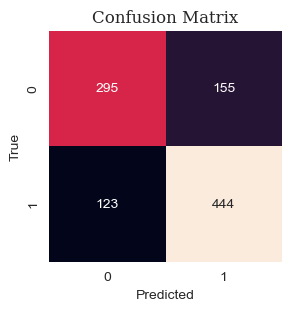

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (3, 3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix', fontsize = 12, fontfamily = 'Serif')
plt.show()

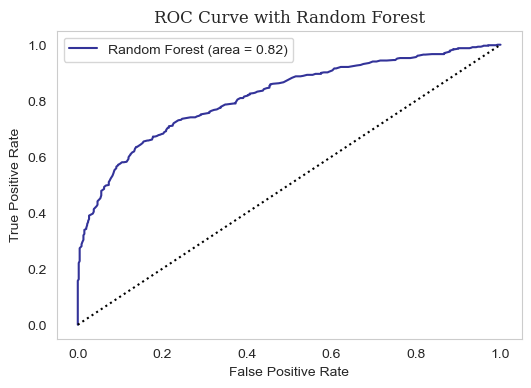

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = 'Random Forest (area = {:.2f})'.format(roc_auc), color = 'navy', alpha = 0.8)
plt.plot([0, 1], [0, 1], 'k:')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Random Forest', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.legend()
plt.show()